# CIFAR-10

This tutorial demonstrates how to build a simple diffusion model with Azula, and train it to generate CIFAR-10 images.

In [1]:
# !pip install datasets

In [2]:
import torch
import torch.nn as nn

from azula.denoise import PreconditionedDenoiser
from azula.nn.embedding import SineEncoding
from azula.nn.unet import UNet
from azula.noise import VPSchedule
from azula.sample import DDIMSampler
from datasets import load_dataset
from einops import rearrange
from PIL import Image
from torch.utils.data import DataLoader
from torchvision.transforms import RandomHorizontalFlip
from torchvision.transforms.functional import to_pil_image, to_tensor
from tqdm import tqdm

device = "cuda"

## Data

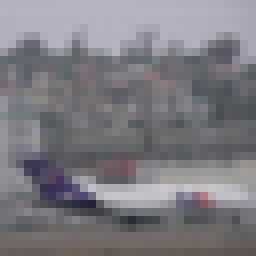

In [3]:
def transform(rows):
    rows["img"] = list(map(to_tensor, rows["img"]))
    rows["label"] = list(map(torch.as_tensor, rows["label"]))
    return rows


cifar10 = load_dataset("cifar10", split="train", keep_in_memory=True)
cifar10 = cifar10.with_transform(transform)

to_pil_image(cifar10[0]["img"]).resize((256, 256), Image.NEAREST)

In [4]:
def preprocess(x):
    return 2 * x - 1

In [5]:
def postprocess(x):
    return torch.clip((x + 1) / 2, min=0, max=1)

## Diffusion model

In [6]:
class UNetWrapper(nn.Module):
    def __init__(self):
        super().__init__()

        self.unet = UNet(
            3, 3, 256, hid_channels=[128, 256, 384], hid_blocks=[3, 3, 3], attention_heads={2: 1}
        )
        self.time_encoding = SineEncoding(256)
        self.label_embedding = nn.Embedding(10, 256)

    def forward(self, x_t, t, label):
        emb = self.time_encoding(t) + self.label_embedding(label)

        x_t = rearrange(x_t, "B (C H W) -> B C H W", C=3, H=32, W=32)
        x_0 = self.unet(x_t, emb)
        x_0 = rearrange(x_0, "B C H W -> B (C H W)")

        return x_0


denoiser = PreconditionedDenoiser(backbone=UNetWrapper(), schedule=VPSchedule()).to(device)

## Training

In [7]:
optimizer = torch.optim.Adam(denoiser.parameters(), lr=1e-4)
averaged = torch.optim.swa_utils.AveragedModel(
    model=denoiser,
    multi_avg_fn=torch.optim.swa_utils.get_ema_multi_avg_fn(0.999),
)

In [ ]:
augment = RandomHorizontalFlip()
batch_size = 256

loader = DataLoader(
    cifar10,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=4,
    persistent_workers=True,
)

for _ in (bar := tqdm(range(64))):
    losses = []

    for batch in loader:
        x = batch["img"].to(device)
        label = batch["label"].to(device)

        x = augment(x)
        x = preprocess(x).reshape(batch_size, -1)

        t = torch.rand((batch_size,), device=device)

        loss = denoiser.loss(x, t, label=label).mean() / (3 * 32 * 32)
        loss.backward()
        losses.append(loss.detach())

        optimizer.step()
        optimizer.zero_grad()

        averaged.update_parameters(denoiser)

    bar.set_postfix(loss=torch.stack(losses).mean().item())

denoiser = averaged.module

 19%|█▉        | 12/64 [09:36<41:34, 47.96s/it, loss=0.688]

## Evaluation

In [ ]:
sampler = DDIMSampler(denoiser, steps=256).to(device)

label = torch.randint(10, size=(), device=device)

x1 = sampler.init((1, 3 * 32 * 32))
x0 = sampler(x1, label=label)

to_pil_image(postprocess(x0).reshape(3, 32, 32)).resize((256, 256), Image.NEAREST)